In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(0, '/home/noah/Desktop/large_analysis/ca_analysis')
import fileread as fr
from scipy.signal import fftconvolve
import predefined as pd
import wave_ops as wo
from scipy import signal
from inspect import signature

def wave(t,*pars):
    t0,tau1,tau2=pars
    return np.heaviside(t-t0,1.)*(np.exp(-(t-t0).astype(float)/tau1)-np.exp(-(t-t0).astype(float)/tau2))

def pixel_cut(array,board,channel):
    return np.logical_and(array['board']==board,array['channel']==channel)

#def precuts(x):
#    x=x[x['energy']>100]
#    x.sort(order='timestamp')
#    t0,t1,t2=x['timestamp'][0:-2],x['timestamp'][1:-1],x['timestamp'][2:]
#    trutharray=land(t2-t1>250,t1-t0>250)
#    x=x[1:-1][trutharray]
#    x=x[lor(x['pileup']<2,x['pilediff']<240)]
#    x=x[x['t0']>100]
#    return x

fac=1

def linearCombine(a1,b1,c,t0,tau,rise):# (N,*pars):
    N=3500
    t=np.arange(N,dtype=float)
    v=np.zeros((3,N),dtype=float) #np.zeros((len(pars),N))
    t=np.arange(N,dtype=float)
    w=2*np.pi/3500.
    v[0,0:N]=a1*np.sin(w*fac*t)
    v[1,0:N]=b1*np.cos(w*fac*t)
    v[2,0:N]=c*wave(t,t0,tau,rise)
    return np.sum(v,axis=0)

def baseline_restore(wave,pretrigger,output):
    '''Bitwise & operation and range restore (-=16384) with a baseline restoration \n Use: >> baseline_restore(wavetorestorebaseline,pretrig) '''
    numwaves = len(wave['wave'])
    wave['wave']=wave['wave']&16383
    wave['wave'][wave['wave']>8192]-=16384
    output[0:numwaves]=np.mean(wave['wave'][0:numwaves,0:pretrigger],axis=1)
    wave['wave']=np.subtract(wave['wave'][0:numwaves],output.reshape((numwaves,1)))#.reshape((numwaves,1)))

means=np.array([1000, 1031.3367, 1086.8575, 1217.0291, 1041.5563, 1000, 1230.2096, 1188.8999,\
                1000, 1263.1642, 1233.1743, 1056.3289, 1213.4717, 1112.0769, 1049.4534, 1219.0482,\
                1000, 1000, 1077.4932, 1157.1627, 1000, 1163.2235, 1000, 1000,\
                1000, 1027.103, 1111.1212, 1033.5468, 1109.469, 1022.693, 1929.7336, 1000,\
                1000, 1124.478, 1073.1306, 1040.2197, 1100.4457, 1045.0566, 1135.8975, 1073.1854,\
                1000, 1000, 1087.187, 1133.1069, 1005.3494, 1000, 1000, 1000])
run='/home/noah/Desktop/large_analysis/ca_analysis/Run_131_0.bin';name=run[-13:-6]
#run='/home/noah/Desktop/large_analysis/ca_analysis/oscillation/Run_0_0.bin';name=run[-11:-6];means=np.ones(48,dtype='float')*1250
numwaves=int((os.stat(run).st_size-8)/7033)
row=0
data=fr.raw(run,length=3500,row=row,numwaves=numwaves-row)
numwaves=len(data)
subset=False
timeordered=True

if subset== True:
    bd,ch=1,3
    data=pd.single_pixel(data,bd,ch)
    numwaves=len(data)
if timeordered==True:
    data=np.sort(data,order='requesttime')
baseline=np.zeros(numwaves,dtype=float)
baseline_restore(data,600,baseline)

In [2]:
fs=35
length=3500
rise,top=400,70
length=len(data['wave'][0])
DesignT=np.array([linearCombine(1,0,0,0,1,1), \
                  linearCombine(0,1,0,0,1,1), \
                  linearCombine(0,0,0,0,1,1)])

Cov=np.matmul(DesignT,DesignT.T)
t=np.arange(length)
traps,shorttraps=np.zeros((48,length)),np.zeros((48,length))
wo.multi_trap(arr=traps,rise=rise,top=top),wo.multi_trap(arr=shorttraps,rise=20,top=0)
out=np.zeros(length)
parray=np.zeros((len(data),12))   #three amp pars, three SE's, s^2, two trap outputs,bin min, binmax
trap=np.array([np.zeros(length)])

loc,s2,maxamp=0.,0.,0.
e=[0]
count=0
for i in range(len(data)):
#for i in range(10000):
    bd,ch=data['board'][i],data['channel'][i]
    bdch=8*bd+ch
    out =signal.fftconvolve(data['wave'][i],shorttraps[bdch],'full')[0:length]
    loc = np.argmax(out)-20
    DesignT[2,0:length]= wave(t,loc,means[bdch],5)
    
    trap[0,0:length]=signal.convolve(data['wave'][i][0:length],traps[bdch,0:length])[0:length]
    wo.trap_energy(traps=trap,length=length,output=e)
    parray[i,7]=e[0]
    parray[i,0:3]=np.matmul(np.matmul(np.linalg.inv(np.matmul(DesignT,DesignT.T)),\
                        DesignT),data['wave'][i,0:length])
    trap[0,0:length]=signal.convolve(data['wave'][i][0:length]-linearCombine(parray[i,0],parray[i,1],\
                                     0,1,1,5),traps[bdch,0:length])[0:length]
    wo.trap_energy(traps=trap,length=length,output=e)
    parray[i,8]=e[0]
    yhat=np.matmul(DesignT.T,parray[i,0:3])
    yhat=data['wave'][i,0:length]-yhat
    s2=np.matmul(yhat.T,yhat)/(length-DesignT.shape[0])
    parray[i,6]=s2
    Cov=np.linalg.inv(np.matmul(DesignT,DesignT.T))  #Now DesignT is the covariance matrix
    parray[i,3:6]=np.sqrt(s2*np.diag(Cov))
    parray[i,9]=np.argmin(linearCombine(parray[i,0],parray[i,1],0,1,1,1))
    parray[i,10]=np.argmax(linearCombine(parray[i,0],parray[i,1],0,1,1,1))
    parray[i,11]=loc
    phi=np.arctan(parray[i,1]/parray[i,0])
    phi=(phi%(2*np.pi))/np.pi
    
    #STUFF IS BEING STORED IN PARRAY!!!!
    plot=False
    if plot==True: #np.sum(np.sqrt(parray[i,0]**2.))>20
        count+=1
        if count ==6:
            p=np.zeros(len(signature(linearCombine).parameters))
            p[0:3]=parray[i,0:3]
            p[3:len(p)]=loc,means[bdch],5
            pretrigger=3500
            plt.figure(figsize=(30,20))
            plt.plot(t,data['wave'][i])
            plt.plot(t,trap[0],label='trap')
            #plt.plot(t[0:len(yhat)],yhat,'ro',label='residuals')
            plt.plot(t,linearCombine(*p),label=r'fit: A={0:0.1f}, $s^2$={1:0.1f}, $\alpha$={2:0.2f} $\phi$= {3:0.2f}'.format(np.sqrt(p[0]**2.+p[1]**2),parray[i,2*(len(p)-3)],p[0]/np.cos(np.arctan(p[1]/p[0])),np.arctan(p[1]/p[0])))
            #plt.plot(t,linearCombine(p[0],0), label=r'sin(${0:0.2f}\omega t)$'.format(fac))
            #plt.plot(t,linearCombine(0,p[1]), label=r'cos(${0:0.2f}\omega t)$'.format(fac))
            plt.plot(t,parray[i,2*(len(p)-3)+1]*np.ones(length),'r--',label='unadjusted energy = {0:0.1f}'.format(parray[i,2*(len(p)-3)+1]))
            plt.plot(t,parray[i,2*(len(p)-3)+2]*np.ones(length),'b--',label='adjusted energy = {0:0.1f}'.format(parray[i,2*(len(p)-3)+2]))
            plt.tick_params(labelsize=fs)
            plt.title(pd.pixel(data['board'][i],data['channel'][i]),fontsize=fs)
            plt.legend(fontsize=fs)
            plt.show()
            break

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


98278
Run_131


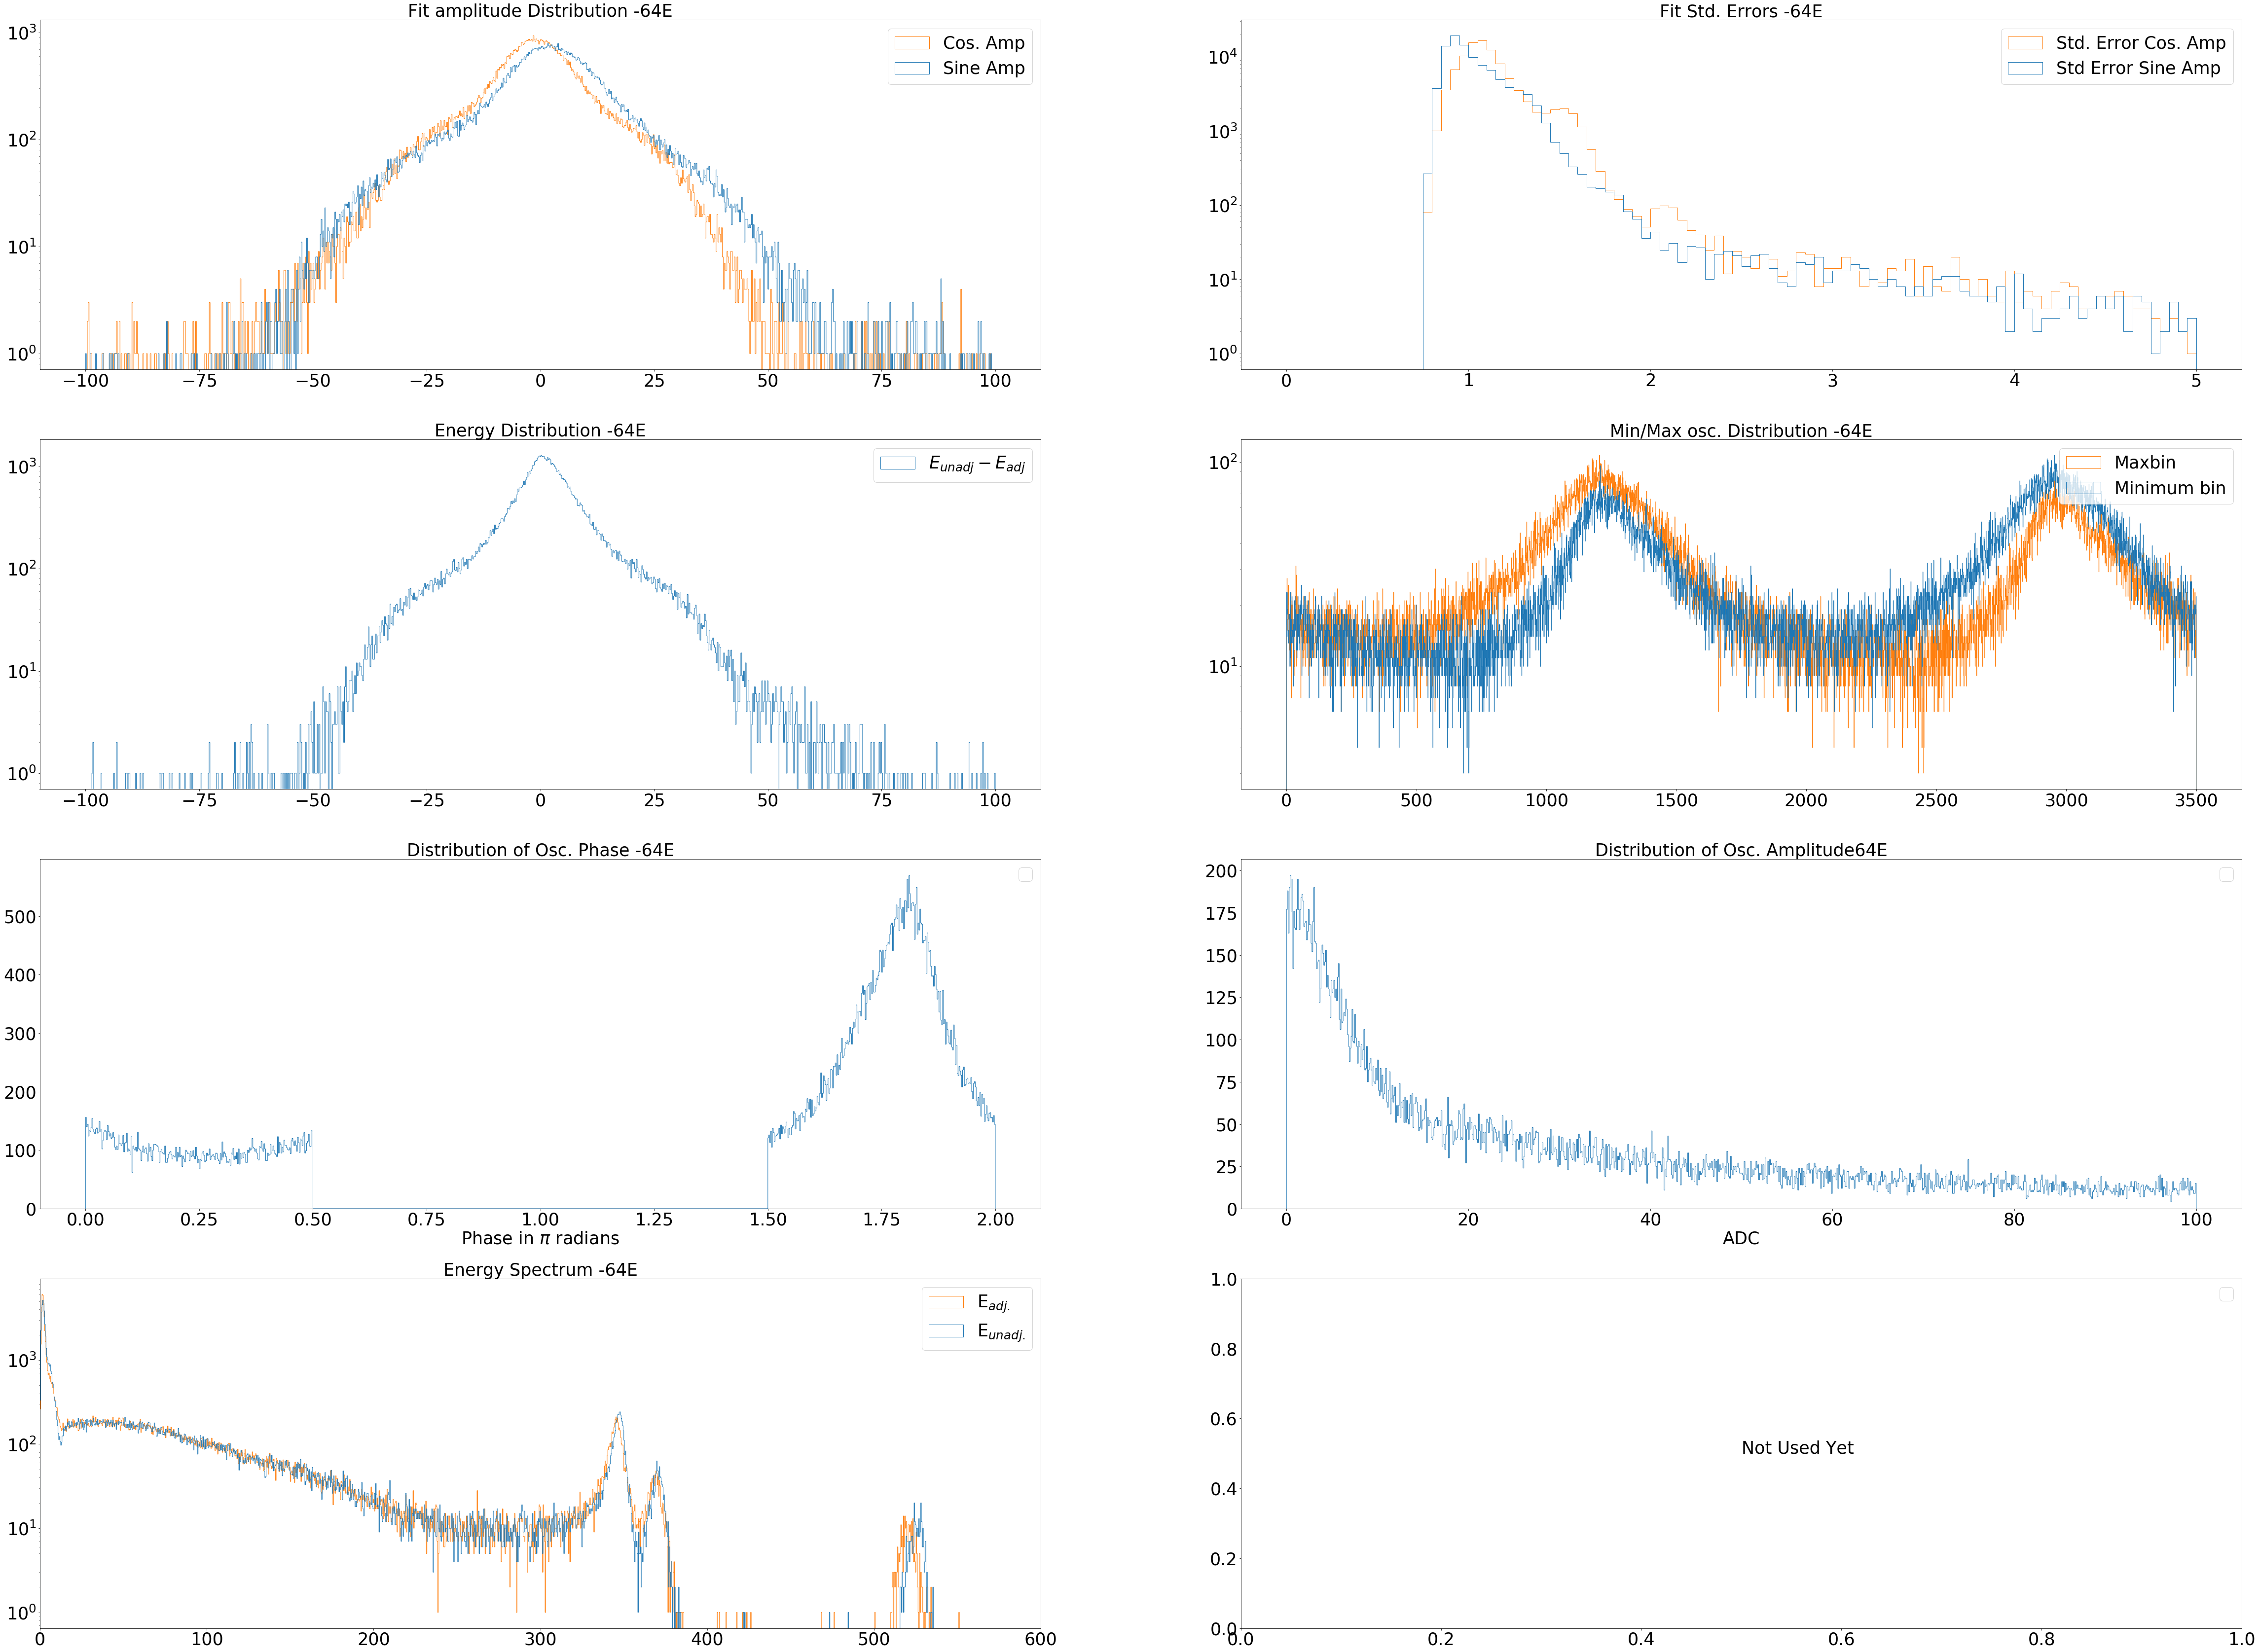

In [6]:
fs=35
loadarray=False
savearray=False
if loadarray==True and savearray == False:
    print(name)
    parray=np.load(name+'.npy')
if savearray == True:
    np.save(name,parray)
bd,ch=4,3
pixelarray=pixel_cut(data,board=bd,channel=ch)
phi=np.arctan(parray[:,1]/parray[:,0])
phi=(phi%(2*np.pi))/np.pi
trutharray=pd.land(pd.land(pixelarray,parray[:,7]>0),parray[:,11]>900)
print(np.sum(trutharray))
phi=phi[trutharray]
#phi=np.arctan(parray[:,1][trutharray]/parray[:,0][trutharray])
oscamp=parray[:,0][trutharray]/np.cos(phi)
fig,ax=plt.subplots(4, 2,figsize=(80,60))
ax[0,0].set_title('Fit amplitude Distribution -'+pd.pixel(bd,ch),fontsize=fs)
ax[0,0].hist(parray[:,0:2][trutharray],bins=1000,range=[-100,100],histtype='step',label=['Sine Amp','Cos. Amp'])
ax[0,0].set_yscale('log')
ax[0,1].set_title('Fit Std. Errors -'+pd.pixel(bd,ch),fontsize=fs)
ax[0,1].hist(parray[:,3:5][trutharray],bins=100,range=[0,5],histtype='step',label=['Std Error Sine Amp','Std. Error Cos. Amp'])
ax[0,1].set_yscale('log')
ax[1,0].set_title(r'Energy Distribution -'+pd.pixel(bd,ch),fontsize=fs)
ax[1,0].hist(parray[:,7][trutharray]-parray[:,8][trutharray],bins=1001,range=[-100,100],histtype='step',label=[r'$E_{unadj} - E_{adj}$','Adjusted E'])
ax[1,0].set_yscale('log')
ax[1,1].set_title(r'Min/Max osc. Distribution -'+pd.pixel(bd,ch),fontsize=fs)
ax[1,1].hist(parray[:,9:11][trutharray],bins=3500,range=[0,3500],histtype='step',label=['Minimum bin','Maxbin'])#[r'$\frac{\chi^2}{DoF}$')
ax[1,1].set_yscale('log')
ax[2,0].set_title('Distribution of Osc. Phase -'+pd.pixel(bd,ch),fontsize=fs)
ax[2,0].hist(phi,bins=1000,range=[0,2],histtype='step')
ax[2,0].set_xlabel(r'Phase in $\pi$ radians',fontsize=fs)
ax[2,1].set_title('Distribution of Osc. Amplitude'+pd.pixel(bd,ch),fontsize=fs)
ax[2,1].hist(oscamp,bins=1000,range=[0,100],histtype='step')
ax[2,1].set_xlabel(r'ADC',fontsize=fs)
ax[3,0].set_title(r'Energy Spectrum -'+pd.pixel(bd,ch),fontsize=fs)
ax[3,0].hist(parray[:,7:9][trutharray]/6.1,bins=2000,range=[0,800],histtype='step',label=[r'E$_{unadj.}$',r'E$_{adj.}$'])
ax[3,0].set_yscale('log')
ax[3,0].set_xlim(0,600)
ax[3,1].text(0.5,0.5,'Not Used Yet',fontsize=fs)
for item in ax.flatten():
    item.tick_params(labelsize=fs)
    item.legend(fontsize=fs)
plt.savefig('tmp-'+name+'-'+pd.pixel(bd,ch)+'.pdf',fmt='pdf')
print(name)
plt.show()

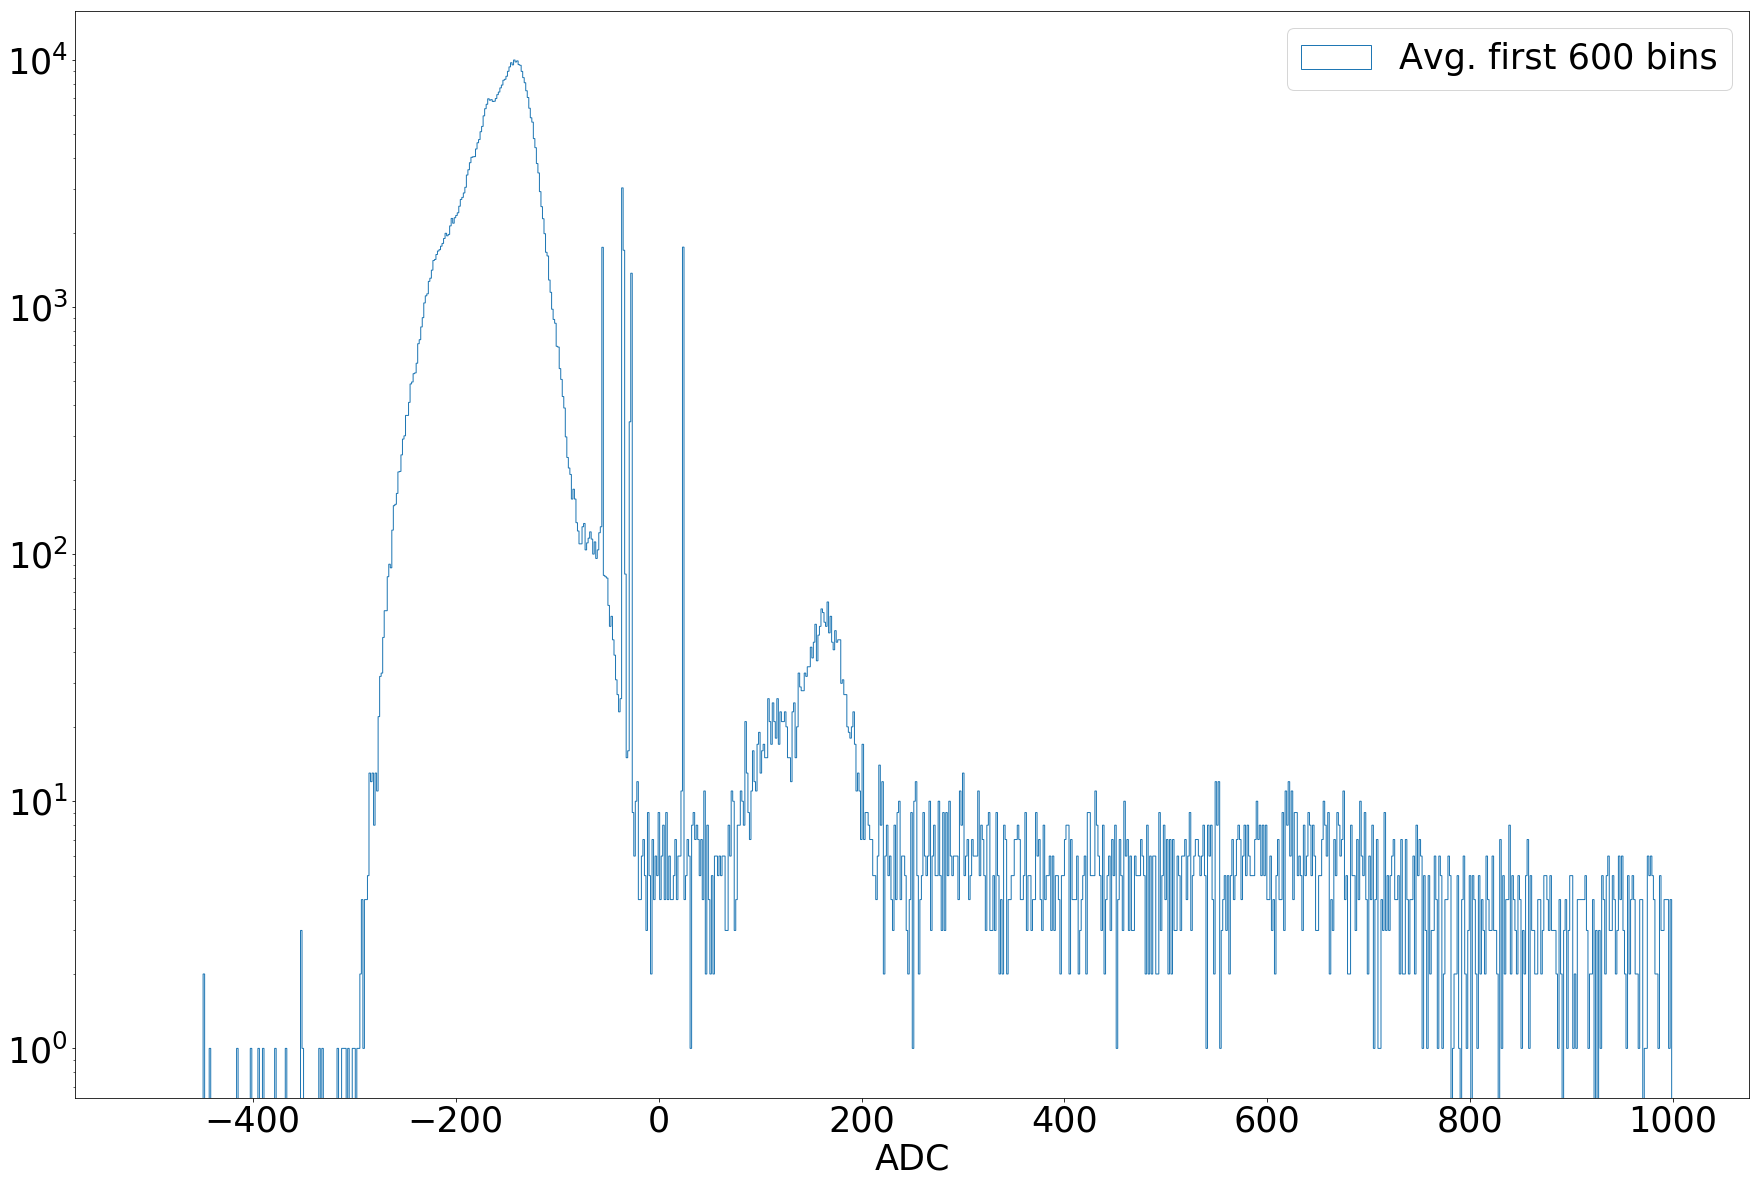

In [5]:
fs=35
plt.figure(figsize=(30,20))
plt.hist(baseline,bins=1000,range=[-500,1000],histtype='step',label='Avg. first 600 bins')
plt.xlabel('ADC',fontsize=fs)
plt.yscale('log')
plt.legend(fontsize=fs)
plt.tick_params(labelsize=fs)
plt.show()